In [3]:
%matplotlib inline
#%pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from libs.utils import montage
from libs import gif
import IPython.display as ipyd

plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
from libs.datasets import MNIST
ds =MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(ds.X.shape)

(70000, 784)


In [4]:
plt.imshow(ds.X[0].reshape((28,28)))

In [5]:
imgs = ds.X[:1000].reshape((-1, 28,28))
plt.imshow(montage(imgs), cmap='gray')

In [6]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28,28)), cmap='gray')

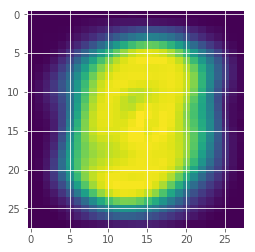

In [36]:
std_img = np.std(ds.X, axis= 0)

plt.figure()
plt.imshow(std_img.reshape(28,28))

In [8]:
tf.reset_default_graph()

In [9]:
dimensions = [784, 512, 256,128, 64]

In [10]:
n_features = ds.X.shape[1]

In [11]:
X = tf.placeholder(tf.float32, [None, n_features])

In [12]:
current_input = X
n_input = n_features
Ws = []
bs = []

for layer_i, n_output in enumerate(dimensions[1:]):
    
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer= tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer= tf.constant_initializer())
        
        h = tf.add(tf.matmul(current_input, W), b)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        n_input = n_output

In [13]:
print(current_input.get_shape())

(?, 64)


In [14]:
Ws = Ws[::-1]

dimensions = dimensions[::-1]
print(dimensions)

[64, 128, 256, 512, 784]


In [15]:
for layer_i, n_output in enumerate(dimensions[1:]):
    
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                initializer=tf.constant_initializer())
        h = tf.add(tf.matmul(current_input, W),b)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output
        
        

In [16]:
Y = current_input

In [17]:
cost = tf.reduce_sum(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [18]:
cost = tf.reduce_mean(cost)

In [19]:
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
batch_size = 100
n_epochs = 10

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train. next_batch():
        sess.run(optimizer, feed_dict = {X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict = {X: examples - mean_img})
    recon = np.clip((recon+mean_img).reshape((-1,28,28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))


0 43.0955
1 39.9587
2 36.7251
3 35.3313
4 35.6194
5 33.0402
6 32.003
7 31.55
8 31.9492
9 31.3627


In [22]:
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [23]:
plt.imshow(imgs[9],cmap='gray')

In [24]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
          height=500, width=500)

In [26]:
tf.reset_default_graph()

In [27]:
X = tf.placeholder(tf.float32, [None, n_features])


In [28]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [29]:
n_filters = [16,16,16]
filter_sizes = [4,4,4]

In [30]:
current_input = X_tensor

n_input = 1
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
   with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
                name='W',
                shape=[
                    filter_sizes[layer_i],
                    filter_sizes[layer_i],
                    n_input,
                    n_output],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.nn.conv2d(current_input, W, strides = [1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output

In [31]:
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters  = n_filters[1:] + [1]
print(n_filters)
print(filter_sizes)
print(shapes)

[16, 16, 1]
[4, 4, 4]
[[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [32]:
for layer_i, shape in enumerate(shapes):
    
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = Ws[layer_i]
        h = tf.nn.conv2d_transpose(current_input, W,
                    tf.pack([tf.shape(X)[0], shape[1],shape[2], shape[3]]),
                    strides=[1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)

In [33]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

9 0.025799
9 0.0259602
9 0.0251556
9 0.0256113
9 0.0257352


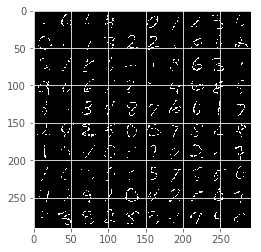

In [40]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 100
n_epochs = 5

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer , feed_dict ={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict = {X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1,28,28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))

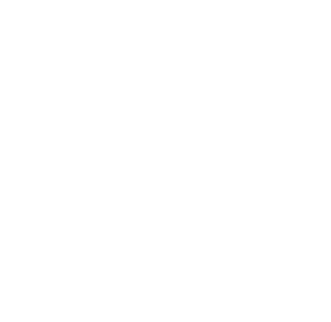

In [42]:
gif.build_gif(imgs, saveto ='conv-ae.gif', cmap='gray')

In [44]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),
          height=500, width=500)

In [4]:
from libs import datasets

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
1


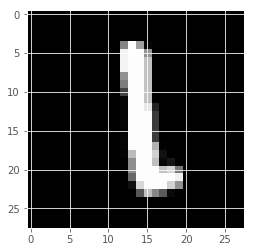

In [5]:
ds = datasets.MNIST(one_hot=False)
print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], (28,28)), cmap='gray')

5


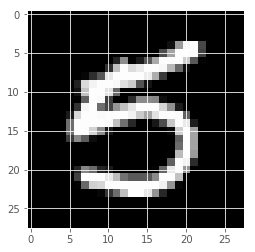

In [6]:
plt.figure()
print(ds.Y[1])
plt.imshow(np.reshape(ds.X[1],(28,28)),cmap='gray')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


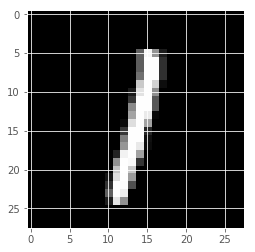

In [7]:
ds = datasets.MNIST(one_hot=True)
plt.figure()
plt.imshow(np.reshape(ds.X[0], (28,28)), cmap='gray')
print(ds.Y[0])

plt.imshow(np.reshape(ds.X[1],(28,28)),cmap='gray')
print(ds.Y[1])

In [8]:
print(ds.X.shape)

(70000, 784)


In [9]:
print(ds.Y.shape)
print(ds.Y[0])

(70000, 10)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [10]:
import tensorflow as tf
from libs import datasets
ds = datasets.MNIST(split=[0.8, 0.1, 0.1])
n_input = 28*28

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
n_output = 10

In [12]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_output])

In [13]:
from libs import utils
Y_pred, W = utils.linear(
                        x=X,
                        n_output=n_output,
                        activation=tf.nn.softmax,
                        name='layer1')

In [14]:
cross_entropy = -tf.reduce_sum(Y*tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [15]:
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y,1)

In [16]:
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 50
n_epochs = 5
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_xs, Y:batch_ys})
    
    valid = ds.valid
    print(sess.run(accuracy, feed_dict={X:valid.images, Y:valid.labels}))
    
test = ds.test
print(sess.run(accuracy, feed_dict={X:test.images, Y: test.labels}))

0.894
0.905857
0.909
0.914286
0.915286
0.922857


In [18]:
g = tf.get_default_graph()

[op.name for op in g.get_operations()]

['Placeholder',
 'Placeholder_1',
 'layer1/W',
 'layer1/W/Initializer/random_uniform/shape',
 'layer1/W/Initializer/random_uniform/min',
 'layer1/W/Initializer/random_uniform/max',
 'layer1/W/Initializer/random_uniform/RandomUniform',
 'layer1/W/Initializer/random_uniform/sub',
 'layer1/W/Initializer/random_uniform/mul',
 'layer1/W/Initializer/random_uniform',
 'layer1/W/Assign',
 'layer1/W/read',
 'layer1/b',
 'layer1/b/Initializer/Const',
 'layer1/b/Assign',
 'layer1/b/read',
 'layer1/MatMul',
 'layer1/h',
 'layer1/Softmax',
 'add/y',
 'add',
 'Log',
 'mul',
 'Const',
 'Sum',
 'Neg',
 'gradients/Shape',
 'gradients/Const',
 'gradients/Fill',
 'gradients/Neg_grad/Neg',
 'gradients/Sum_grad/Reshape/shape',
 'gradients/Sum_grad/Reshape',
 'gradients/Sum_grad/Shape',
 'gradients/Sum_grad/Tile',
 'gradients/mul_grad/Shape',
 'gradients/mul_grad/Shape_1',
 'gradients/mul_grad/BroadcastGradientArgs',
 'gradients/mul_grad/mul',
 'gradients/mul_grad/Sum',
 'gradients/mul_grad/Reshape',
 'grad

In [19]:
W = g.get_tensor_by_name('layer1/W:0')

In [21]:
W_arr = np.array(W.eval(session=sess))
print(W_arr.shape)

(784, 10)


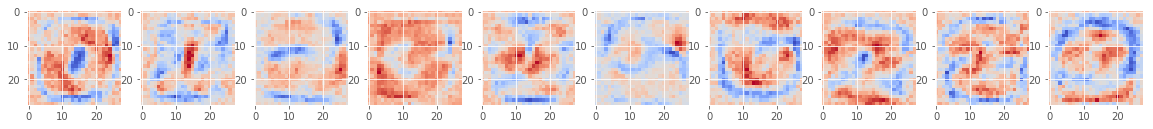

In [22]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for col_i in range(10):
    ax[col_i].imshow(W_arr[:, col_i].reshape((28,28)), cmap='coolwarm')

In [24]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [25]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [26]:
ds = datasets.MNIST(one_hot=True, split=[0.8, 0.1, 0.1])
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [27]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [28]:
filter_size = 5
n_filters_in = 1
n_filters_out = 32
W_1 = tf.get_variable(
            name='W',
            shape=[filter_size, filter_size, n_filters_in, n_filters_out],
            initializer=tf.random_normal_initializer())

In [30]:
b_1 = tf.get_variable(
            name='b',
            shape=[n_filters_out],
            initializer=tf.constant_initializer())

In [31]:
h_1 = tf.nn.relu(
            tf.nn.bias_add(
                    tf.nn.conv2d(input=X_tensor,
                                 filter=W_1,
                                 strides=[1,2,2,1],
                                 padding='SAME'),
                    b_1))

In [ ]:
n_filters_in =32
n_filters_out = 64